# 08. PyTorch Paper Replicating

We try to turn a ML research paper into usable code!

In this notebook, the Vision Transformer architecture will be replicated: https://arxiv.org/pdf/2010.11929

## 0. Get Setup

In [1]:
import torch
import torchvision

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 45.21 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

We want to replicate the ViT architecture for the FoodVision Mini problem.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
    ])

print(f"Manual transforms:\n{manual_transforms}")

Manual transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32 #actually 4096 which is a bit too much to run smoothly...

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a Single Image

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0] # let's just use the first one

print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 224, 224])
Label: 1


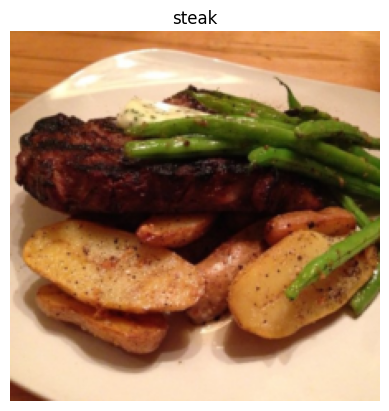

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Let's break the ViT architecture into smaller pieces:
* **Inputs** - What goes into models?
* **Outputs** - What comes out of the model/layer/block?
* **Layer** - Takes an input and manipulates it.
* **Block** A collection of layers.
* **Model** - A collection of blocks.

### 3.1 ViT Overview: Pieces of the Puzzle

* Figure 1: visual overview of the architecture
* Four equations: math defining the functions of blocks/layers
* Table 1/3: hyperparameters
* Text

#### **Equation 1**
In pseudocode:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]
```

#### **Equations 2 and 3**
In pseudocode:
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
#### **Equation 4**
In pseudocode:
```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

## 4. Equation 1: Splitting Data into Patches and Creating the Class, Position and Patch Embedding

### 4.1 Calculate Input and Output Shapes by Hand

* Input shape: (224, 224, 3) (single image: H, W, C)
* Output shape
* Input image: $H\times W\times C$
* Output image: ${N \times\left(P^{2} \cdot C\right)}$
* $H$ = height
* $W$ = width
* $C$ = color channels
* $P$ = patch size
* $N$ = number of patches = $(H \times W / p^{2}$)
* $D$ = constant latent vector size = embedding dimension

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number of patches, embedding_dimensions)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number of patches, embedding_dimensions)


### 4.2 Turning a Single Image into Patches

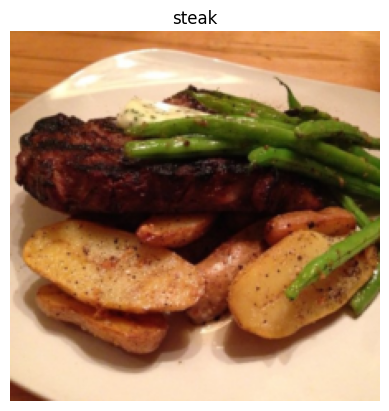

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

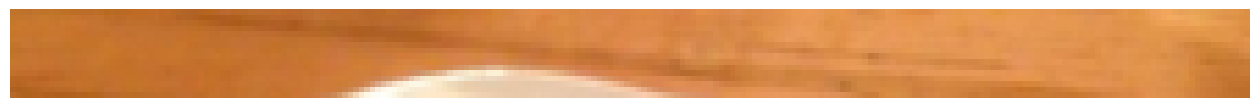

In [13]:
# Get the top row
image_permuted = image.permute(1, 2, 0) # H, W, C
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

Num of patches per row: 14.0
Patch size: 16 * 16 pixels


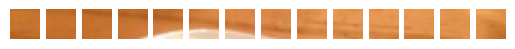

In [14]:
# Plot top row as batches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size!"
print(f"Num of patches per row: {num_patches}")
print(f"Patch size: {patch_size} * {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True)

# iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].axis(False);

Num of patches per row: 14.0
Num of patches per col: 14.0
Total patches: 196.0
Patch size: 16 * 16 pixels


Text(0.5, 0.98, 'steak -> Patchified')

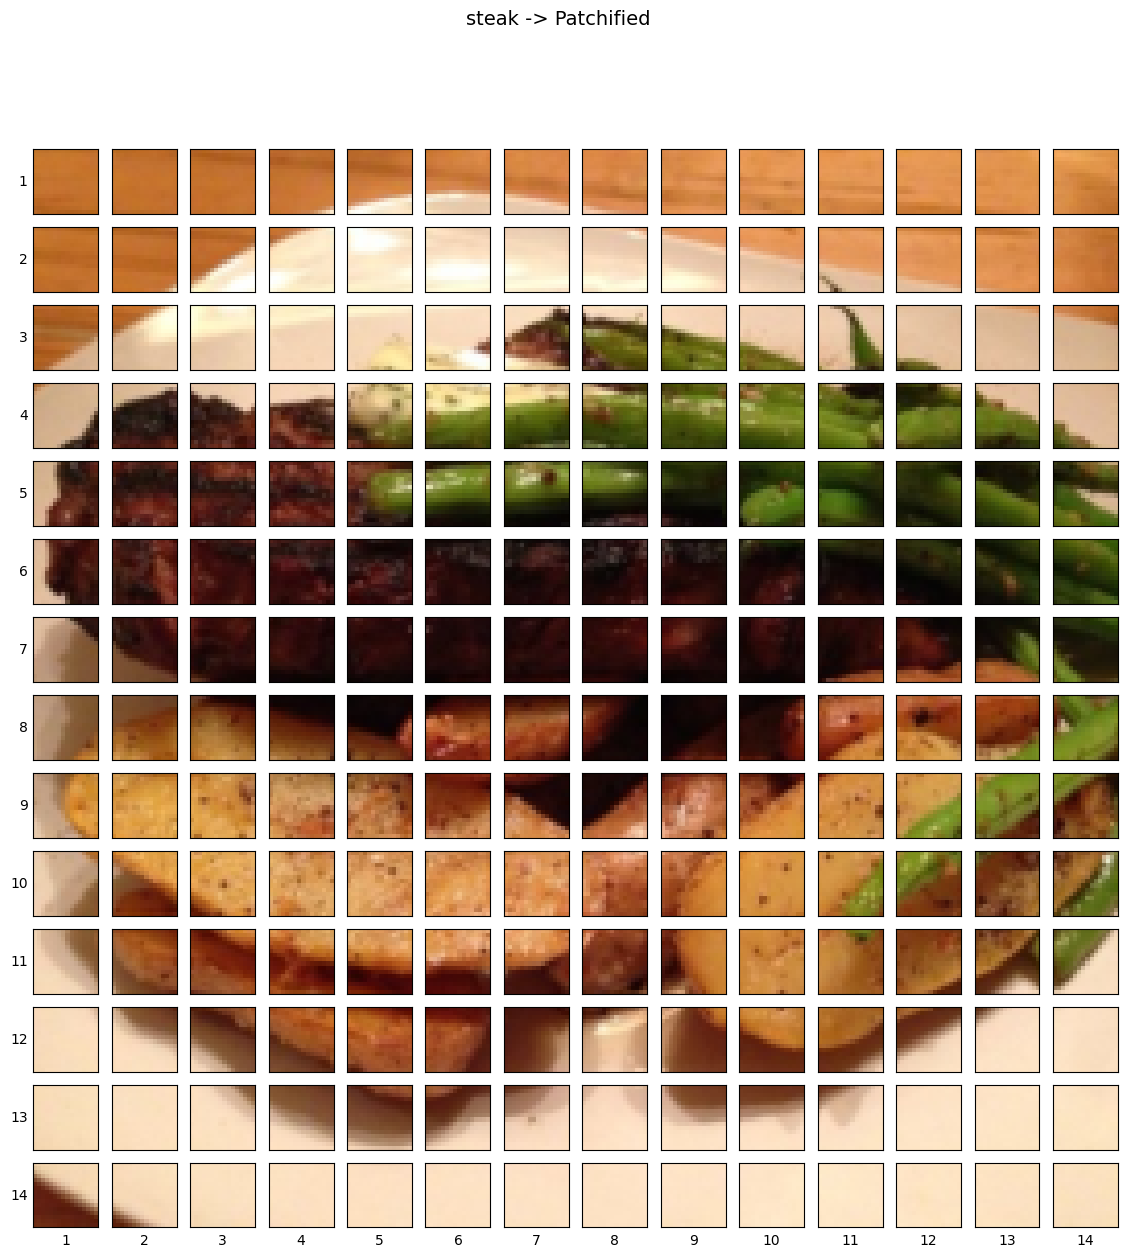

In [15]:
# Let's do whole image!
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size!"
print(f"Num of patches per row: {num_patches}")
print(f"Num of patches per col: {num_patches}")
print(f"Total patches: {num_patches * num_patches}")
print(f"Patch size: {patch_size} * {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :])
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)

### 4.3 Creating Image Patches and Turning Them into Embeddings

Let's use `torch.nn.Conv2d()` with suitable parameters set as `patch_size`to create image patches and embeddings with one step!

In [16]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # D
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

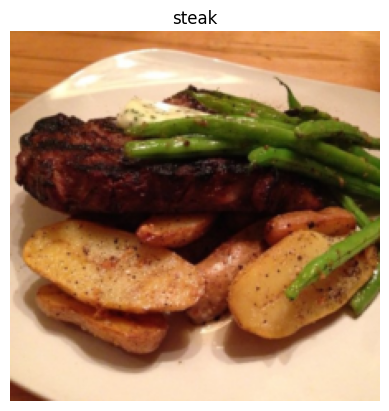

In [17]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now the shape of our image is [1, 768, 14, 14] = [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indices: [383, 273, 533, 511, 685]


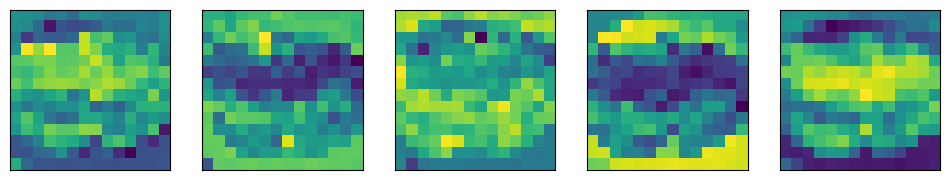

In [19]:
# Plot random convolutional feature maps (embeddings)
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indices: {random_indices}")

fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        sharex=True,
                        sharey=True,
                        figsize=(12,12))

for i, idx in enumerate(random_indices):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, remove from grad tracking, change to numpy format
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2519, -0.2568, -0.2345, -0.2269, -0.2411, -0.2280, -0.3016,
           -0.3164, -0.3137, -0.3127, -0.2986, -0.2947, -0.3102, -0.3248],
          [-0.2454, -0.2442, -0.1960, -0.3657, -0.4179, -0.3361, -0.3640,
           -0.3489, -0.3082, -0.2581, -0.2727, -0.3195, -0.2653, -0.2690],
          [-0.1738, -0.3489, -0.4213, -0.3967, -0.4545, -0.3916, -0.3168,
           -0.3619, -0.3462, -0.3371, -0.2943, -0.2626, -0.3102, -0.2173],
          [-0.3335, -0.1250, -0.3126, -0.2133, -0.3040, -0.4200, -0.1776,
           -0.1700, -0.2022, -0.1793, -0.1150, -0.1684, -0.3616, -0.2593],
          [-0.1173, -0.0330, -0.0860, -0.0894, -0.1435, -0.1030, -0.1145,
           -0.1300, -0.0336, -0.1277, -0.1230, -0.0538, -0.0616, -0.1150],
          [-0.1148, -0.0223, -0.0386, -0.0264,  0.0064, -0.0390, -0.0286,
           -0.0043, -0.0364,  0.0047, -0.0348, -0.0552, -0.0434, -0.1725],
          [-0.1686, -0.1016, -0.0128, -0.0029,  0.0056,  0.0258, -0.0019,
           -0.0044,  0.0242,  0.

### 4.4 Flattening the Patch Embedding with `torch.nn.Flatten()`

In [21]:
print(F"{image_out_of_conv.shape} -> (batch_size, embedding_dim, height, width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, height, width)


In [22]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image shape: torch.Size([1, 768, 196])


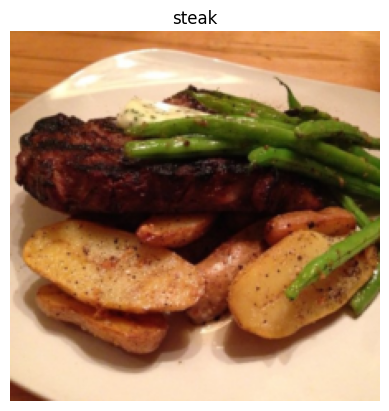

In [23]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Rearrange output
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} = [batch_size, num_of_patches, embedding_dimension]")

torch.Size([1, 196, 768]) = [batch_size, num_of_patches, embedding_dimension]


Text(0.5, 1.0, 'Flattened feature map shape: torch.Size([1, 196])')

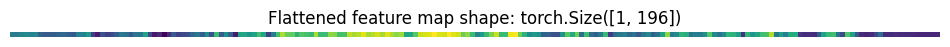

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

plt.figure(figsize=(12,12))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False);
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")

### 4.5 Turning the ViT Patch Embedding Layer into a PyTorch Module

We want this module to:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size
3. Create a layer to turn an image into embedded patches using `nn.Conv2d`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()` that defines the forward computation (e.g. pass through the layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [26]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from Table 1 for ViT
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                                    end_dim=3)

  def forward(self, x):
    # check correct input shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input size muzt be divisible by patch size, image size: {image_resolution}, patch_size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)

In [27]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding size: {patch_embedded_image.shape}")


Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding size: torch.Size([1, 196, 768])


In [28]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)
#patchify(rand_image_tensor_bad)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the Class Token Embedding

Now we want to prepend a learnable class token to the start of the patch embedding.

In [29]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [30]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [31]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # ones just to notice :)
class_token.shape

torch.Size([1, 1, 768])

In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # num of patches dimension!
print(patch_embedded_image_with_class_embedding)
print(f"Image with class token shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + num of patches, embedding_size)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5906,  0.0427, -0.0475,  ...,  0.3162, -0.3077,  0.2385],
         [-0.5924,  0.0470, -0.0709,  ...,  0.3055, -0.3018,  0.2432],
         ...,
         [-0.9549,  0.2258, -0.2308,  ...,  0.6931, -0.4555,  0.3492],
         [-0.9489,  0.2232, -0.2336,  ...,  0.6822, -0.4457,  0.3538],
         [-0.9465,  0.2163, -0.2255,  ...,  0.6719, -0.4481,  0.3450]]],
       grad_fn=<CatBackward0>)
Image with class token shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + num of patches, embedding_size)


### 4.7 Creating the Position Embedding

Now we want to create a series of 1D position embeddings!

In [33]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5906,  0.0427, -0.0475,  ...,  0.3162, -0.3077,  0.2385],
          [-0.5924,  0.0470, -0.0709,  ...,  0.3055, -0.3018,  0.2432],
          ...,
          [-0.9549,  0.2258, -0.2308,  ...,  0.6931, -0.4555,  0.3492],
          [-0.9489,  0.2232, -0.2336,  ...,  0.6822, -0.4457,  0.3538],
          [-0.9465,  0.2163, -0.2255,  ...,  0.6719, -0.4481,  0.3450]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [34]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, # again ones to notice :)
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [35]:
# Add the position embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4094, 1.0427, 0.9525,  ..., 1.3162, 0.6923, 1.2385],
         [0.4076, 1.0470, 0.9291,  ..., 1.3055, 0.6982, 1.2432],
         ...,
         [0.0451, 1.2258, 0.7692,  ..., 1.6931, 0.5445, 1.3492],
         [0.0511, 1.2232, 0.7664,  ..., 1.6822, 0.5543, 1.3538],
         [0.0535, 1.2163, 0.7745,  ..., 1.6719, 0.5519, 1.3450]]],
       grad_fn=<AddBackward0>)
Shape of patch and position embedding: torch.Size([1, 197, 768])


### 4.8 Putting It All Together: from Image to Embedding

Let's do this in one cell!

In [36]:
set_seeds()

patch_size = 16

print(f"Image shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,
                                      embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding),
                                       dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihiead Self-Attention (MSA Block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch --> this relationship needs to be learned!
* LayerNorm = normalizing distributions of intermediate layers to enable smoother gradients, faster training and better generalization accuracy.

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block (MSA).
  """
  def __init__(self,
               embedding_dim: int = 768, # Hidden size D (embedding dimension) from Table 1
               num_heads: int = 12, # Heads from Table 1
               attn_dropout: int = 0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first dimension? (batch, seq, feature) -> (batch, num_of_batches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [38]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Patched image through MSA block shape: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Patched image through MSA block shape: torch.Size([1, 197, 768])


In [39]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4094, 1.0427, 0.9525,  ..., 1.3162, 0.6923, 1.2385],
         [0.4076, 1.0470, 0.9291,  ..., 1.3055, 0.6982, 1.2432],
         ...,
         [0.0451, 1.2258, 0.7692,  ..., 1.6931, 0.5445, 1.3492],
         [0.0511, 1.2232, 0.7664,  ..., 1.6822, 0.5543, 1.3538],
         [0.0535, 1.2163, 0.7745,  ..., 1.6719, 0.5519, 1.3450]]],
       grad_fn=<AddBackward0>)

In [40]:
patched_image_through_msa_block

tensor([[[-0.2118, -0.2428,  0.0469,  ..., -0.4117,  0.8799, -0.4380],
         [-0.2029, -0.2383,  0.0496,  ..., -0.4075,  0.9066, -0.4607],
         [-0.2032, -0.2373,  0.0502,  ..., -0.4070,  0.9066, -0.4610],
         ...,
         [-0.2046, -0.2305,  0.0548,  ..., -0.4087,  0.9105, -0.4617],
         [-0.2047, -0.2307,  0.0547,  ..., -0.4087,  0.9106, -0.4617],
         [-0.2046, -0.2308,  0.0544,  ..., -0.4088,  0.9105, -0.4616]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP)

* **MLP** contains two layers with a GELU non-linearity
  * MLP = a quite broad term for a block with a series of layers, either multiple or even only one hidden layer
* **Dropout** (for ViT) is applied after every dense layer except for the qkv-projections and directly after adding positional to patch embeddings.

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```


In [41]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072, # from Table 1
               dropout: int = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.mlp(self.layer_norm(x))

In [42]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Patched image through MLP block shape: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Patched image through MLP block shape: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

Let's combine everything to create the transformer encoder!

There are also residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = turn a learnable representation back into a sequence
* Residual connections = add a layer's input to its' subsequent output - enables deeper networks by preventing weights getting too small

In pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Creating a Custom Transformer Encoder Block

In [43]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: int = 0.1,
               attn_dropout: int = 0):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [44]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch size, number of patches, embedding dim)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with Built-In PyTorch Layers

We can also use `PyTorch`'s ready transformer layers!

In [45]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch size, number of patches, embedding dim)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why we spent all the time recreating the transformer encoder when we can just use PyTorch?

Practice.

Now we know what happens behind the scenes.

Benefits of using a built-in PyTorch layer:
 * Less prone to errors
 * Potential benefit of speedups

## 8. Putting All Together to Create ViT

In [47]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layers: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: int = 0,
               mlp_dropout: int = 0.1,
               embedding_dropout: int = 0.1,
               num_classes: int = 1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size ({img_size}) must be divisible by patch size ({patch_size})"

    self.num_patches = (img_size * img_size) // patch_size ** 2

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim),
                                          requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, # * just makes these layers sequential
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    # Equation 1
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x) # dropout after layers

    # Equations 2 and 3
    x = self.transformer_encoder(x) # put through transformer encoder

    # Equation 4 = put the 0th index logit through a classifier
    x = self.classifier(x[:, 0])

    return x

In [48]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=3)
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a Visual Summary of our ViT

In [49]:
from torchinfo import summary
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting Up Training of ViT Model

### 9.1 Creating an Optimizer

The paper uses Adam optimizer with $\beta1$ of 0.9 and $\beta2$ of 0.999 and a weight decay of 0.1.

* Weight decay = a regularization technique which adds a small penalty, usually the L2 norm of all the weights of the model, to the loss function to prevent overfitting.

### 9.2 Creating a Loss Function

The paper does not mention any loss function - since we have a multi-class classification problem, we use cross-entropy loss.

## 9.3 Training our ViT

In [50]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6697 | train_acc: 0.3086 | test_loss: 1.2545 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3203 | test_loss: 1.0593 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3925 | train_acc: 0.4219 | test_loss: 1.3158 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2488 | train_acc: 0.4219 | test_loss: 2.3024 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.5335 | train_acc: 0.2852 | test_loss: 1.9660 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.5853 | train_acc: 0.3164 | test_loss: 1.2593 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3238 | train_acc: 0.4375 | test_loss: 1.1766 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2108 | train_acc: 0.2617 | test_loss: 1.9692 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.5777 | train_acc: 0.2891 | test_loss: 1.4056 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1396 | train_acc: 0.4219 | test_loss: 1.1256 | test_acc: 0.5417


### 9.4 What is Missing from our Setup?

Why did we get that bad results compared to the ViT paper?

The main problem is the scale difference of training data...

We could also prevent underfitting with:
* Learning rate warmup
* Learning rate decay
* Gradient clipping

### 9.5 Plotting Loss Curves

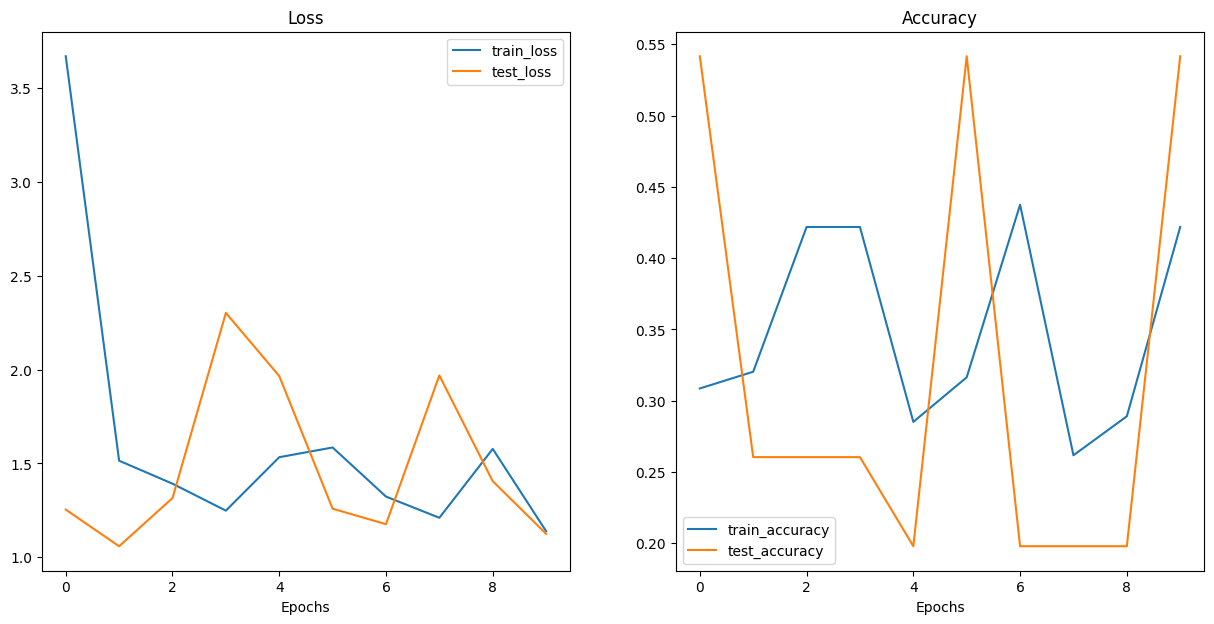

In [51]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a Pretrained ViT from `torchvision.models`

Generally, using a pretrained model, is a good way to start in deep learning problems. It usually achieves nice results even with small amount of data. Let's try!

In [52]:
import torch
import torchvision

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [54]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for param in pretrained_vit.parameters():
  param.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 179MB/s]


In [55]:
from torchinfo import summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.1 Preparing Data for the Pretrained ViT

In [56]:
# Automatic transforms
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [57]:
from going_modular.going_modular import data_setup

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

## 10.2 Train Feature Extractor ViT Model

In [58]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.3 Plot the Loss Curves

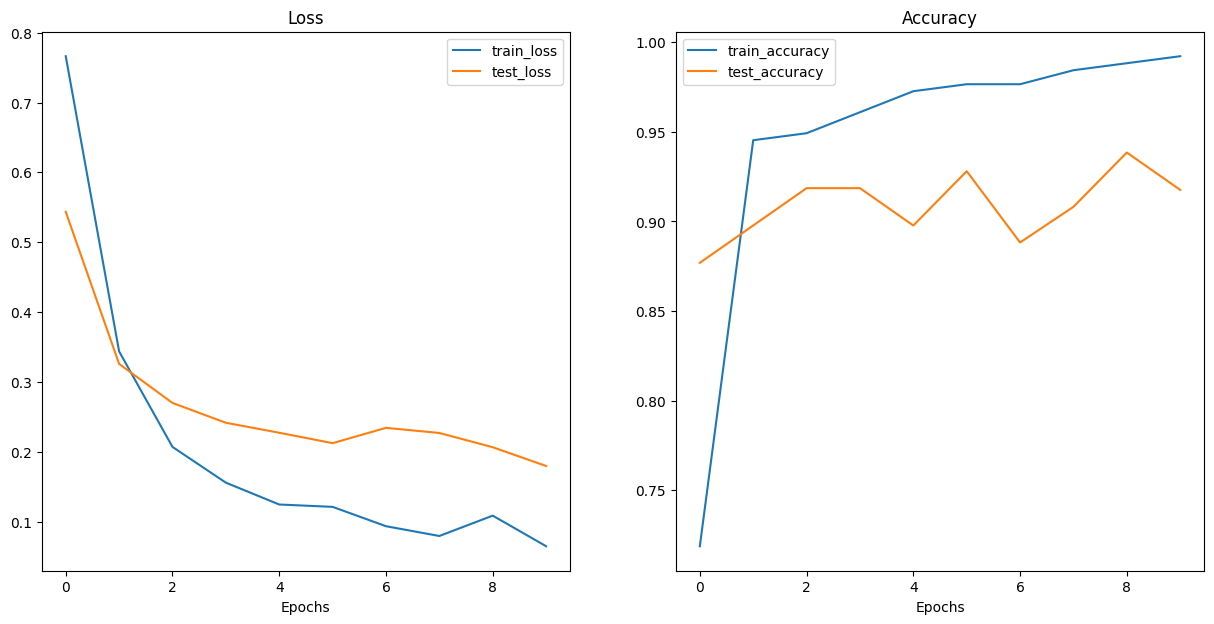

In [59]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.4 Saving the Best Model

In [60]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit.pth")

[INFO] Saving model to: models/08_pretrained_vit.pth


In [61]:
from pathlib import Path
pretrained_vit_model_size = Path("models/08_pretrained_vit.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 327 MB


The ViT gets nice results, but it is ~11x bigger than our next best performing model...

## 11. Predicting on a Custom Image

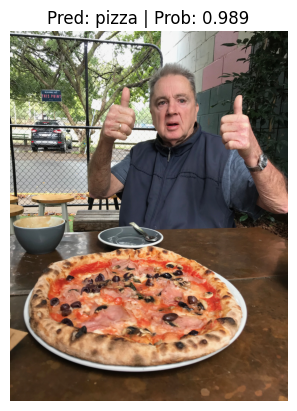

In [62]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)